# AGH - Deep Learning in Medical Image Analysis I

Author: Marek Wodziński

Contact: wodzinski@agh.edu.pl

You are allowed to use these materials for all purposes as long as the credit is given.

# Laboratory 8 - Medical Image Generation

## Introduction

The goal of the laboratory is to implement two basic deep architectures dedicated to the medical image generation.

Medical image generation produces synthetic images/volumes based on the previously acquired knowlege (not only images). The generated images may be used for various task, e.g. image augmentation, synthetic-based training, annotation-transfer, domain adaptation or others.

We are going to implement two basic models - the Autoencoder and the Variational Autoencoder. Their performance is far from the state-of-the-art like the famous DALL-E from OpenAI, however, they are good introductory examples.

During the laboratory you are going to use exactly the same dataset as during the Laboratory 5 - the dataset presenting the XRay images of lungs. The dataset can be downloaded from: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia, however, it is recommended to use the previously downloaded files.

The laboratory is splited into two parts - the Laboratory 8 consists of implementing and training Autoencoder and Variational Autoencoder, while the Laboratory 9 (continuation) is dedicated to explore the latent spaces and to implement the Generative Adversarial Networks (GANs).

Let's start with the required libraries:

In [1]:
import os
import numpy as np
import torch as tc
import torchvision as tv
import pandas as pd
import matplotlib.pyplot as plt
!pip install SimpleITK
import SimpleITK as sitk
from torch.utils.tensorboard import SummaryWriter
from PIL import Image as im

2024-06-08 17:11:01.509820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 17:11:01.509932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 17:11:01.604655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Part I - Dataset and Dataloader

Now, similarly to the previous notebooks, let's implement the dedicated dataset. In fact, you are going to use the slightly modified dataset from the Laboratory 5.

First, define the pathes and (optionally, if not done yet) - unzip the dataset.

In [2]:
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download prashant268/chest-xray-covid19-pneumonia

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
100%|██████████████████████████████████████▉| 2.05G/2.06G [00:09<00:00, 217MB/s]
100%|███████████████████████████████████████| 2.06G/2.06G [00:09<00:00, 222MB/s]


In [3]:
input_file = "chest-xray-covid19-pneumonia.zip" # Path to the "archive.zip"
output_folder = "/kaggle/working" # Path to the folder where you would like to unzip the "archive.zip"
# Note - it will require about 5GB of free Google Drive memory.

print(f"Input file path: {input_file}")
print(f"Output folder path: {output_folder}")

!unzip {input_file} -d {output_folder}  # Do this only once, them comment out this command

Input file path: chest-xray-covid19-pneumonia.zip
Output folder path: /kaggle/working
Archive:  chest-xray-covid19-pneumonia.zip
  inflating: /kaggle/working/Data/test/COVID19/COVID19(460).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(461).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(462).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(463).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(464).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(465).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(466).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(467).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(468).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(469).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(470).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(471).jpg  
  inflating: /kaggle/working/Data/test/COVID19/COVID19(472).jpg  
  inflating: 

Now modify the dataset from the Laboratory 5. This time:
<ul>
<li> We are not going to use ResNet18 so it is not mandatory to have three channels. Since the images are 2-D XRay (gray) images, a single channel is enough.
<li> We are not interested in the image labels, just the images themselves. Therefore, the class mapper is not necessary. The dataset should return only the loaded and preprocessed image (1x224x224 normalized to [0-1] range).
</ul>

In [4]:
class XRayDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.dataframe = pd.read_csv(self.csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image Path'])
            
        try:
            img = tv.io.read_image(current_path, mode=tv.io.ImageReadMode.GRAY)
        except:
            img = np.array(im.open(current_path).convert('L'))
            if len(img.shape) == 2:
                img = tc.tensor(img).unsqueeze(0)
            else:
                raise ValueError("Inappropriate shape after grayscale conversion")
        
        img = tv.transforms.Resize((224, 224), antialias=True)(img) # antialias for warning suppression
        img = img.float() / tc.max(img)

        current_image = img
        return current_image

Now create the .csv file (similarly to the Laboratory 5), however, this time merge all the datasets together. We are not going to split the dataset into training, validation, and test sets because this time we are not interested in generalizability into previously unseen cases, but the quality of the generated images. Of course, if the method would be used to e.g. perform the image augmentation, then the validation / testing datasets used for classification should not be used during training the generative network dedicated to the image augmentation.

Create the .csv file containing just a single column: Image Path

In [5]:
csv_path = os.path.join(output_folder, "data.csv") # TODO
data_path = os.path.join(output_folder, "Data")

dataset = []
for set_type in ["train", "test"]:
    path_to_set = os.path.join(data_path, set_type)
    for folder_name in os.listdir(path_to_set):
        for case_name in os.listdir(os.path.join(path_to_set, folder_name)):
            current_case = os.path.join(path_to_set, folder_name, case_name)
            dataset.append(current_case)
            
dataframe = pd.DataFrame(dataset, columns=["Image Path"])
dataframe.to_csv(csv_path, index=False)
print(f"Dataset size: {len(dataframe)}")

Dataset size: 6432


Check whether the implemented dataset works correctly and prepare visualization similar to the one from Laboratory 5:

Dataset size: 6432


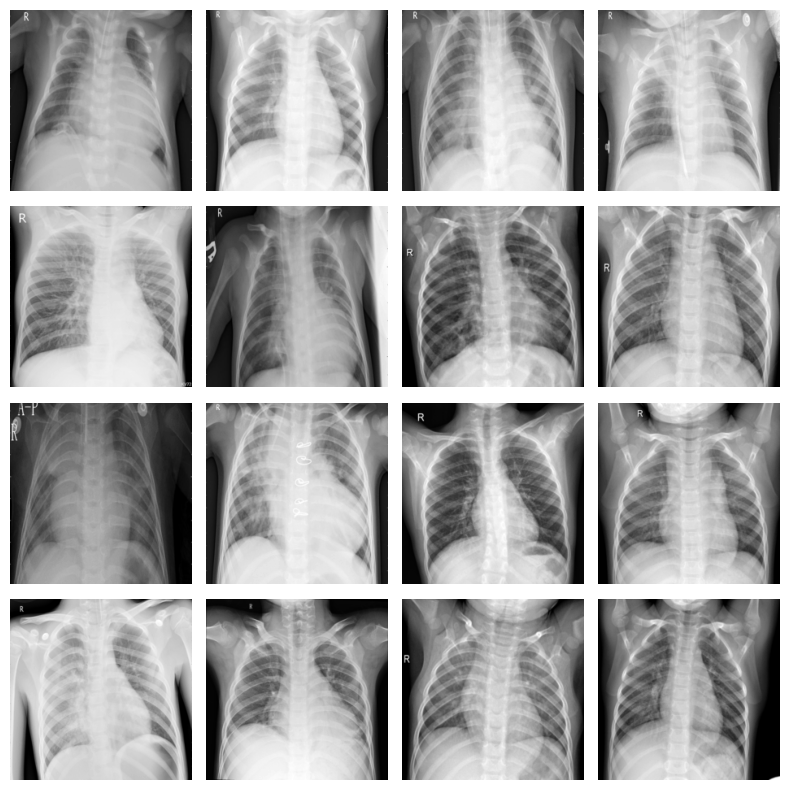

In [6]:
batch_size = 16
shuffle = True
dataset = XRayDataset(data_path, csv_path)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

print(f"Dataset size: {len(dataset)}")

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for images in dataloader:
#     print(images)
    for i, image in enumerate(images):
        row_id, col_id = divmod(i, 4)
#         row_id = i // 4
#         col_id = i % 4
#         print(image.shape)
        axs[row_id][col_id].imshow(image.moveaxis(0, -1), cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break

## Part II - Autoencoder

This part is dedicated to the Autoencoder (AE). You are going to implement and train a simple architecture dedicated to a self-reconstruction. For a good introduction please see the following blog post: https://medium.com/ai%C2%B3-theory-practice-business/understanding-autoencoders-part-i-116ed2272d35

Autoencoder is generally an encoder-decoder architecture like U-Net. However, the task of autoencoder is to directly reconstruct the input. It means that the encoder should first create the embedding, and then the decoder should decode the embedding to the originally provided input. 

At first look this does not make much sense. However, this approach is acutally useful for the network pretraining and the image generation.

1) Network pretraining - the autoencoder does not require any annotations to be trained, just the raw images. Therefore, it is possible to pretrain the network with a large unlabeled dataset before fine-tuning with the smaller, annotated one.

2) Image generation - after pretraining the network, one could then generate new images by generating random embeddings and them passing them through the decoder. This is our goal for today and intuitevely the autoencoder should perform the task well. However, we will observe that this is not exactly the case and discuss how to improve.

Let's start with implementing the autoencoder architecture. Use the U-Net architecture from the Laboratory 6 with the following changes:
<ul>
  <li> Delete all the skip connections between the encoder and decoder. The reason for this is the fact that during the desired image generation, the decoder will not have the information from the encoder, just the low-dimensional embedding.
  <li> Delete the final Sigmoid activation function.
  <li> Modify the latent representation to be 1-D vector with 256 features.
  <li> Replace the BatchNorm2d in the Decoder with the InstanceNorm2d.
  <li> Replace ReLU with the LeakyReLU with slope equal to 0.05
  <li> Implement an additional function called generate that randomly generates a desired number of images. 
</ul>

In [7]:
class Encoder(tc.nn.Module): 
    def __init__(self):
        super(Encoder, self).__init__()
        
        input_channels      = [ 1,  64, 128, 256, 512]  # First layer now takes 1 channel
        output_channels     = [64, 128, 256, 512, 512]
        
        self.layers = tc.nn.ModuleList()
        
        for idx, (in_ch, out_ch) in enumerate(zip(input_channels, output_channels)):
            if idx != len(input_channels) - 1:
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.BatchNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1), #
                        tc.nn.BatchNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.MaxPool2d(kernel_size=2, stride=2),                         #
                    ).to(device)
                )
            else:
#                 print("Last layer")
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.BatchNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05)
                    ).to(device)
                )
        
        self.last_layer_shape = (512, 14, 14)
        self.f = tc.nn.Linear(np.prod(self.last_layer_shape), 256).to(device)
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1).to(device)  # Flatten with respect to batches
        latent_space = self.f(x)
        return latent_space

class Decoder(tc.nn.Module):
    def __init__(self, first_layer_shape):
        super(Decoder, self).__init__()
        
        self.first_layer_shape = first_layer_shape
        self.f = tc.nn.Linear(256, np.prod(self.first_layer_shape)).to(device)
        
        input_channels      = [512, 512, 256, 128, 64]
        output_channels     = [512, 256, 128,  64, 32]
        
        last_layer_channels = 1
        
        self.layers = tc.nn.ModuleList()
        
        for idx, (in_ch, out_ch) in enumerate(zip(input_channels, output_channels)):
            if idx != 0:
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2),     #
                        
                        tc.nn.InstanceNorm2d(in_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.InstanceNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1), #
                        tc.nn.InstanceNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                    ).to(device)
                )
            else:
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.InstanceNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05)
                    ).to(device)
                )
                
        self.layers.append(
            tc.nn.Conv2d(output_channels[-1], last_layer_channels, kernel_size=1, stride=1, padding=0).to(device)
        )
    
    def forward(self, x):
        x = self.f(x)
        x = x.view(x.size(0), *self.first_layer_shape).to(device)  # Reshape
        for idx, layer in enumerate(self.layers):
            x = layer(x)
        return x

class AutoEncoder(tc.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        last_layer_shape = self.encoder.last_layer_shape
        self.decoder = Decoder(first_layer_shape=last_layer_shape)
        
    def encode(self, x):
        return self.encoder(x)

    def decode(self, latent_space):
        return self.decoder(latent_space)

    def generate(self, num_samples):
        latent_space = tc.randn(num_samples, 256).to(device)
        return self.decode(latent_space)

    def forward(self, x):
        x = x.to(device)
        latent_space = self.encode(x)
        reconstructed = self.decode(latent_space)
        return reconstructed


And now simply verify whether the input images are passed thorugh the network correctly, and whether the generate function generates new tensors. Obiviously, the network is not trained yet so it is not necessary to visualize the reconstructions or the generated images.

In [8]:
import gc
gc.collect()
tc.cuda.empty_cache()

In [9]:
device = tc.device('cuda:0' if tc.cuda.is_available() else 'cpu')

ae_model = AutoEncoder()
for images in dataloader:
    output = ae_model(images)
    print(f"Output shape: {output.shape}")
    generated_images = ae_model.generate(images.size(0))
    print(f"Reconstructed images shape: {generated_images.shape}")
    break

Output shape: torch.Size([16, 1, 224, 224])
Reconstructed images shape: torch.Size([16, 1, 224, 224])


Now implement the training function. It should be straightforward, use just MSE between the output and the input as the unsupervised objective function during the training. Use Tensorboard to keep track of the reconstruction error. You may optionally also log several exemplary generated/reconstructed images with a given epoch interval.

In [10]:
from tqdm import tqdm

def training(model, dataloader, reconstruction_function, optimizer, num_epochs, logger, device):
    model.to(device)
    model.train()
    print("Starting training.")
    
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch [{epoch}/{num_epochs}]")
        epoch_loss = 0.0
        
        for batch_idx, images in enumerate(dataloader): # tqdm(enumerate(dataloader), desc=f"Epoch: {epoch}, batch:", total=len(dataloader)):
            images = images.to(device)
            optimizer.zero_grad()
            
            output = model(images)
            loss = reconstruction_function(output, images)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(dataloader)
        logger.add_scalar('Loss/train', avg_epoch_loss, epoch)
        
        # Optionally log some images
                
        print(f'Loss: {avg_epoch_loss:.4f}\n')
    
    print("End of training.")

Now initialize the Tensorboard:

In [11]:
%load_ext tensorboard
%tensorboard --logdir logs/tensorboard

The training parameters:

In [12]:
learning_rate = 0.003
ae_model = AutoEncoder()
batch_size = 16
num_epochs = 50
parameters = ae_model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = tc.device('cuda:0' if tc.cuda.is_available() else 'cpu')
logger = SummaryWriter("/content/logs", comment="AutoEncoder")
reconstruction_function = lambda a, b: tc.mean((a-b)**2)

dataset = XRayDataset(data_path, csv_path)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

And run the training:

In [13]:
training(ae_model, dataloader, reconstruction_function, optimizer, num_epochs, logger, device)

Starting training.
Epoch [1/50]
Loss: 0.0334

Epoch [2/50]
Loss: 0.0111

Epoch [3/50]
Loss: 0.0085

Epoch [4/50]
Loss: 0.0077

Epoch [5/50]
Loss: 0.0068

Epoch [6/50]
Loss: 0.0062

Epoch [7/50]
Loss: 0.0059

Epoch [8/50]
Loss: 0.0056

Epoch [9/50]
Loss: 0.0056

Epoch [10/50]
Loss: 0.0052

Epoch [11/50]
Loss: 0.0050

Epoch [12/50]
Loss: 0.0049

Epoch [13/50]
Loss: 0.0045

Epoch [14/50]
Loss: 0.0048

Epoch [15/50]
Loss: 0.0043

Epoch [16/50]
Loss: 0.0042

Epoch [17/50]
Loss: 0.0041

Epoch [18/50]
Loss: 0.0041

Epoch [19/50]
Loss: 0.0038

Epoch [20/50]
Loss: 0.0037

Epoch [21/50]
Loss: 0.0037

Epoch [22/50]
Loss: 0.0036

Epoch [23/50]
Loss: 0.0036

Epoch [24/50]
Loss: 0.0035

Epoch [25/50]
Loss: 0.0034

Epoch [26/50]
Loss: 0.0032

Epoch [27/50]
Loss: 0.0034

Epoch [28/50]
Loss: 0.0031

Epoch [29/50]
Loss: 0.0030

Epoch [30/50]
Loss: 0.0030

Epoch [31/50]
Loss: 0.0030

Epoch [32/50]
Loss: 0.0029

Epoch [33/50]
Loss: 0.0028

Epoch [34/50]
Loss: 0.0027

Epoch [35/50]
Loss: 0.0027

Epoch [36/

Finally, verify the reconstruction ability: for the training set.

[]

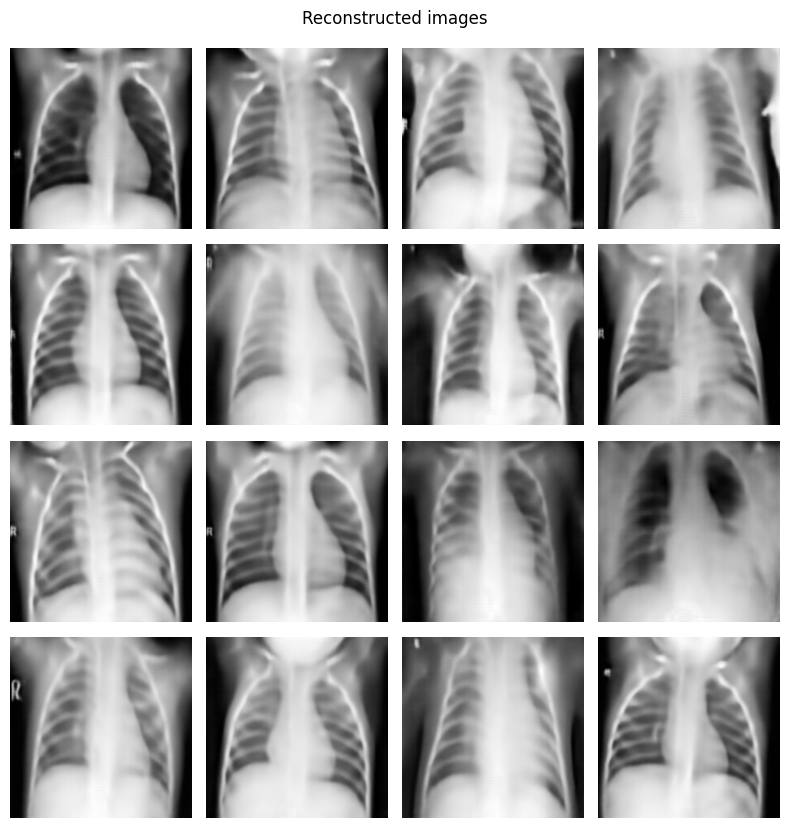

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
ae_model.eval()
for images in dataloader:
    re_imgs = ae_model(images.to(device)).detach().cpu()
    for i, image in enumerate(re_imgs):
        row_id, col_id = divmod(i, 4)
        
        axs[row_id][col_id].imshow(image.moveaxis(0, -1), cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break
plt.suptitle("Reconstructed images", y=1.03)
plt.plot()

And the generation ability:

[]

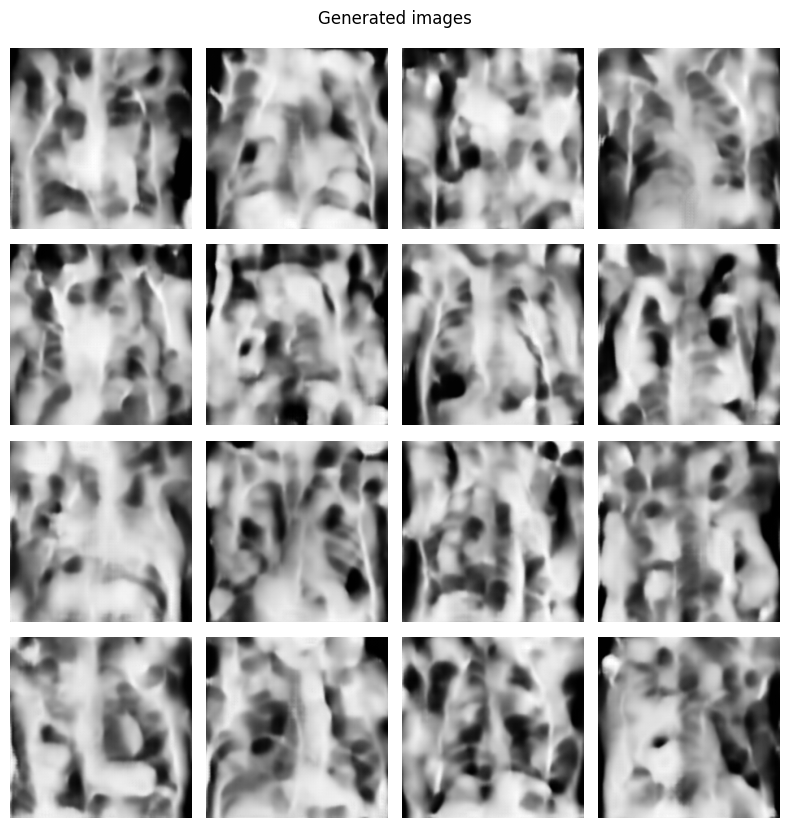

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
ae_model.eval()
for images in dataloader:
    re_imgs = ae_model.generate(16).detach().cpu()
    for i, image in enumerate(re_imgs):
        row_id, col_id = divmod(i, 4)
        
        axs[row_id][col_id].imshow(image.moveaxis(0, -1), cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break
plt.suptitle("Generated images", y=1.03)
plt.plot()

You can observe that the images are reconstructed quite well. However, the generated images contain a lot of artifacts and it can be clearly seen that they are unreal. The reason for this is the irregular latent space that we are going to discuss during the next part of the notebook - the Variational Autoencoder. You are going to visualize the latent spaces during Laboratory 9.

Finally, save the model state dict to your Google Drive. It will be required during the next laboratory:

In [16]:
models_dir = "models"
model_name = "ae_model.pt"

model_path = os.path.join(models_dir, model_name)
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

tc.save(ae_model.state_dict(), model_path)

## Part III - Variational Autoencoder

The Autoencoder generated just a random images. This is connected with with "empty holes" in the latent spaces. The network is unable to generate new images from the space between the aforeseen embeddings. You will visualize this during next laboratory, now you are going to solve this by implementing the Variational Autoencoder (VAE).

Please refer to the lecture or read: https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68

You are going to use almost exactly the same architecture as for the Autoencoder, however, this time you are going to add another layer between the encoder and the decoder. You should add two Linear layers mapping from the 256-dimensional embedding into two 256-dimensional vectors: the mean and the variance. Then you are going to define a normal distribution using these vectors (see tc.distributions.Normal) and sample a new vector from the defined distribution. The generated vector is going to be the the input to the decoder.

Refer to the description above and the provided reference and modify the Autoencoder architecture into the Variational Autoencoder:

In [17]:
class VariationalEncoder(tc.nn.Module): 
    def __init__(self):
        super(VariationalEncoder, self).__init__()
        
        input_channels      = [1, 64, 128, 256, 512]  # First layer now takes 1 channel
        output_channels     = [64, 128, 256, 512, 512]
        self.latent_dim     = 256
        
        self.layers = tc.nn.ModuleList()
        
        for idx, (in_ch, out_ch) in enumerate(zip(input_channels, output_channels)):
            if idx != len(input_channels) - 1:
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.BatchNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1), #
                        tc.nn.BatchNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.MaxPool2d(kernel_size=2, stride=2),                         #
                    ).to(device)
                )
            else:
#                 print("Last layer")
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.BatchNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05)
                    ).to(device)
                )
        
        self.last_layer_shape = (512, 14, 14)
        self.flattened_size = np.prod(self.last_layer_shape)
#         self.f = tc.nn.Linear(np.prod(self.last_layer_shape), 256)
        self.f_mean   = tc.nn.Linear(self.flattened_size, self.latent_dim).to(device)
#         self.f_logvar = tc.nn.Linear(self.flattened_size, self.latent_dim).to(device)
#         self.f_logvar = tc.nn.Sequential(
#             tc.nn.Linear(self.flattened_size, self.latent_dim),
#             tc.nn.Softmax(0)
#         ).to(device)

        self.f_logvar = tc.nn.Sequential(
            tc.nn.Linear(self.flattened_size, self.latent_dim),
            tc.nn.Softplus()
        ).to(device)

    def forward(self, x):
        x = x.to(device)
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)  # Flatten with respect to batches
#         latent_space = self.f(x)
        mean = self.f_mean(x).to(device)
        logvar = self.f_logvar(x) # + 1e-6
        return mean, logvar

class VariationalDecoder(tc.nn.Module):
    def __init__(self, first_layer_shape):
        super(VariationalDecoder, self).__init__()
        
        self.first_layer_shape = first_layer_shape
        self.f = tc.nn.Linear(256, np.prod(self.first_layer_shape)).to(device)
        
        input_channels      = [512, 512, 256, 128, 64]
        output_channels     = [512, 256, 128,  64, 32]
        
        last_layer_channels = 1
        
        self.layers = tc.nn.ModuleList()
        
        for idx, (in_ch, out_ch) in enumerate(zip(input_channels, output_channels)):
            if idx != 0:
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.ConvTranspose2d(in_ch, in_ch, kernel_size=2, stride=2),     #
                        
                        tc.nn.InstanceNorm2d(in_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.InstanceNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                        
                        tc.nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1), #
                        tc.nn.InstanceNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05),
                    ).to(device)
                )
            else:
                self.layers.append(
                    tc.nn.Sequential(
                        tc.nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),  #
                        tc.nn.InstanceNorm2d(out_ch),
                        tc.nn.LeakyReLU(negative_slope=0.05)
                    ).to(device)
                )
                
        self.layers.append(
            tc.nn.Conv2d(output_channels[-1], last_layer_channels, kernel_size=1, stride=1, padding=0).to(device)
        )
    
    def forward(self, x):
        x = self.f(x)
        x = x.view(x.size(0), *self.first_layer_shape)  # Reshape
        for layer in self.layers:
            x = layer(x)
        return x

class VariationalAutoEncoder(tc.nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = VariationalEncoder()
        last_layer_shape = self.encoder.last_layer_shape
        self.decoder = VariationalDecoder(first_layer_shape=last_layer_shape)
        
    def encode(self, x):
        mean, logvar = self.encoder(x)
        self.mean, self.logvar = mean.to(device), logvar.to(device)
        z = self.reparameterization(self.mean, self.logvar)
        return z, self.mean, self.logvar

    def decode(self, x):
        return self.decoder(x)

    def generate(self, num_samples):
        z = tc.randn(num_samples, 256).to(device)
        return self.decode(z)
    
    def reparameterization(self, mean, logvar):
#         logvar = tc.clamp(logvar, min=-10, max=2).to(device)
#         epsilon = tc.randn_like(logvar).to(device) # sampling from normal(0, 1)
        epsilon = tc.normal(mean=tc.zeros(16, 256).to(device), std=tc.ones(16, 256).to(device)/10).to(device)
#         z = mean + logvar * epsilon
        z = mean.to(device) + tc.exp(logvar/2).to(device) * epsilon
        return z

    def forward(self, x):
        z, mean, logvar = self.encode(x)
        reconstructed = self.decode(z.to(device))
        return reconstructed, z, mean, logvar


Again, check whether the inputs are propagated correctly:

In [18]:
vae_model = VariationalAutoEncoder()
for images in dataloader:
    output, _, _, _ = vae_model(images)
    print(f"Output shape: {output.shape}")
    generated_images = vae_model.generate(images.size(0))
    print(f"Generated images shape: {generated_images.shape}")
    break

Output shape: torch.Size([16, 1, 224, 224])
Generated images shape: torch.Size([16, 1, 224, 224])


In [19]:
for images in dataloader:
    output = vae_model.generate(len(images))
    print(f"Output shape: {output.shape}")
    generated_images = vae_model.generate(images.size(0))
    print(f"Generated images shape: {generated_images.shape}")
    break

Output shape: torch.Size([16, 1, 224, 224])
Generated images shape: torch.Size([16, 1, 224, 224])


Reimplement the training loop. Now there will be two weighted terms in the objective function (see previous image registration task) - one responsible for the evaluation the reconstruction quality, and a second one responsible for enforcing a given distribution within the latent space. You are going to use the Kullback-Leiber divergence implemented below. 

Implement the training loop:

In [20]:
from tqdm import tqdm

def training(model, dataloader, reconstruction_function, distribution_function, lambda_distribuion, 
             optimizer, num_epochs, logger, device):
    model.to(device)
    print("Starting training.")
    
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch: [{epoch}/{num_epochs}]")
        model.train()
        epoch_loss = 0.0
        epoch_reconstruction_loss = 0.0
        epoch_distribution_loss = 0.0
        
#         with tqdm(enumerate(dataloader), desc=f"Epoch: {epoch}", total=len(dataloader)) as pbar:
        for batch_idx, images in enumerate(dataloader):

            images = images.to(device)
            optimizer.zero_grad()

            reconstructed, z, mean, logvar = model(images)

            reconstruction_loss = reconstruction_function(reconstructed, images)
            kl_divergence = distribution_function(mean, tc.exp(0.5 * logvar).to(device))

            loss = reconstruction_loss + lambda_distribution * kl_divergence
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_distribution_loss += kl_divergence.item()

            if epoch_distribution_loss > 1e25:
                print(f"Epoch batch {batch_idx} loss:   {loss.item()}")
                print(f"Epoch batch {batch_idx} r_loss: {epoch_reconstruction_loss}")
                print(f"Epoch batch {batch_idx} d_loss: {epoch_distribution_loss}")
                raise Exception("Distribution_loss is too large.")
#             pbar.set_postfix({
#                 'loss': loss.item(),
#                 'r_loss': reconstruction_loss.item(),
#                 'd_loss': kl_divergence.item()
#             })
            
        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(dataloader)
        avg_epoch_reconstruction_loss = epoch_reconstruction_loss / len(dataloader)
        avg_epoch_distribution_loss = epoch_distribution_loss / len(dataloader)
        
        logger.add_scalar('Loss/train', avg_epoch_loss, epoch)
        logger.add_scalar('Loss/reconstruction', avg_epoch_reconstruction_loss, epoch)
        logger.add_scalar('Loss/distribution', avg_epoch_distribution_loss, epoch)
        
        # Optionally log some images
        
#         print(f"Epoch: [{epoch}/{num_epochs}]")
        print(f"Epoch loss:   {avg_epoch_loss}")
        print(f"Epoch r_loss: {avg_epoch_reconstruction_loss}")
        print(f"Epoch d_loss: {avg_epoch_distribution_loss}\n")
            
    print("End of training.")

Now initialize the training parameters:

In [21]:
# def kld(mean, std):
#     """
#     Direct KL divergence (for all-sized batches)
#     """
#     p = tc.distributions.Normal(tc.zeros_like(mean), tc.ones_like(std))
#     q = tc.distributions.Normal(mean, std)
#     kl = tc.distributions.kl_divergence(q, p)
#     kl = kl.mean()
#     return kl 
def kld(mean, log_var):
    return - 0.5 * tc.sum(1+ log_var - mean.pow(2) - log_var.exp())

learning_rate = 0.003
device = tc.device('cuda:0' if tc.cuda.is_available() else 'cpu')
vae_model = VariationalAutoEncoder()
batch_size = 16
num_epochs = 50
parameters = vae_model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
logger = SummaryWriter("/content/logs/VAE", comment="VariationalAutoEncoder")
reconstruction_function = lambda a, b: tc.mean((a-b)**2)
distribution_function = kld
lambda_distribution = 0.003

dataset = XRayDataset(data_path, csv_path)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Initialize the Tensorboard:

In [22]:
import gc
gc.collect()
tc.cuda.empty_cache()

And run the training:

In [23]:
try:
    training(vae_model, dataloader, reconstruction_function, distribution_function, lambda_distribution, optimizer, num_epochs, logger, device)
except:
    print("Training encountered infinite loss")

Starting training.
Epoch: [1/50]
Epoch loss:   126.51578526117315
Epoch r_loss: 0.037126551136671015
Epoch d_loss: 42159.552006811646

Epoch: [2/50]
Epoch loss:   9.619969174636537
Epoch r_loss: 0.030937366581415358
Epoch d_loss: 3196.343900614117

Epoch: [3/50]
Epoch loss:   10.768812459499681
Epoch r_loss: 0.03068467057240543
Epoch d_loss: 3579.3758963969217

Epoch: [4/50]
Epoch loss:   12.916044015789506
Epoch r_loss: 0.030561963554972142
Epoch d_loss: 4295.1606448349075

Epoch: [5/50]
Epoch loss:   10.936687805166292
Epoch r_loss: 0.030590032815784957
Epoch d_loss: 3635.365903332459

Epoch: [6/50]
Epoch loss:   4.619656641091874
Epoch r_loss: 0.030235076165614435
Epoch d_loss: 1529.807178706079

Epoch: [7/50]
Epoch loss:   4.515581269762409
Epoch r_loss: 0.02966110364751733
Epoch d_loss: 1495.306713806456

Epoch: [8/50]
Epoch loss:   4.505545396709916
Epoch r_loss: 0.029223227901245232
Epoch d_loss: 1492.107374504431

Epoch: [9/50]
Epoch loss:   4.732164159936098
Epoch r_loss: 0.02

Implement visualization of the reconstruced and generated images as before:

[]

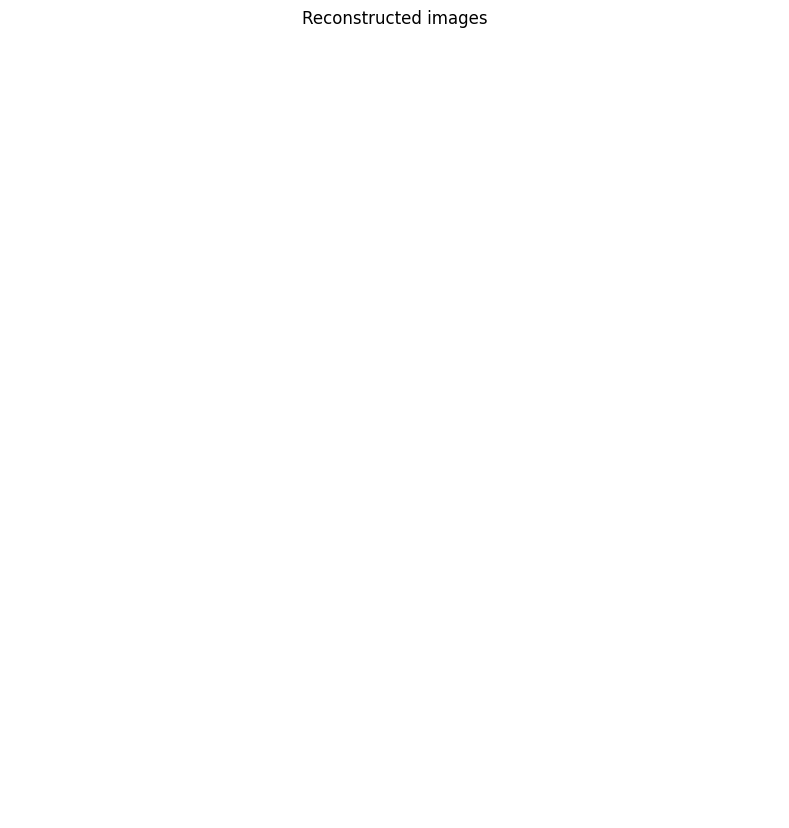

In [24]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
vae_model.eval()
for images in dataloader:
    re_imgs, _, _, _ = vae_model(images.to(device))
    re_imgs = re_imgs.detach().cpu()
    for i, image in enumerate(re_imgs):
        row_id, col_id = divmod(i, 4)
        
        axs[row_id][col_id].imshow(image.moveaxis(0, -1), cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break
plt.suptitle("Reconstructed images", y=1.03)
plt.plot()

[]

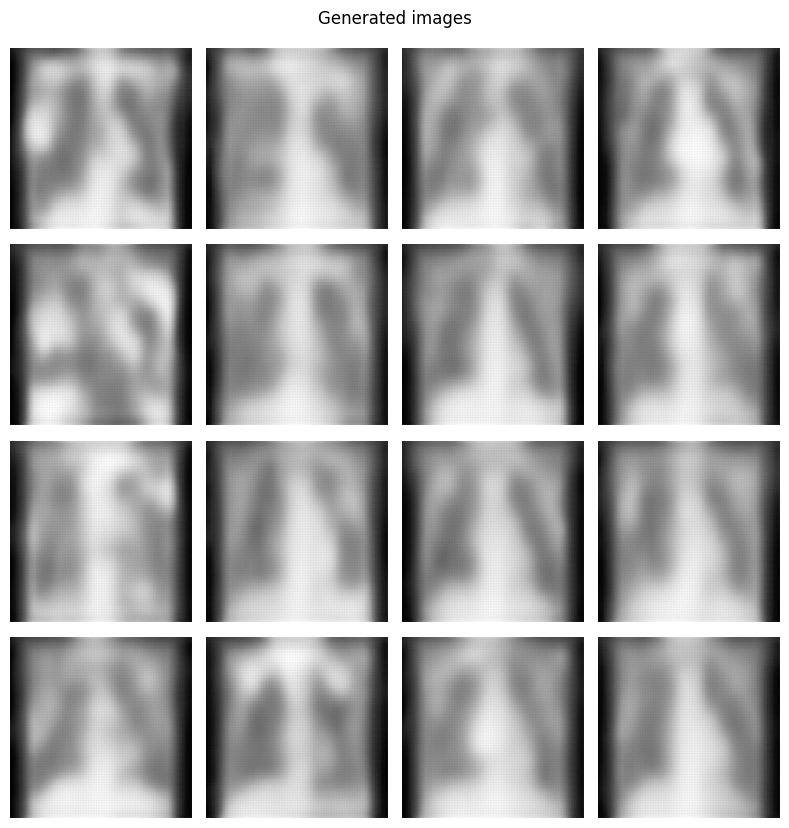

In [25]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
vae_model.eval()
for images in dataloader:
    re_imgs = vae_model.generate(16).detach().cpu()
    for i, image in enumerate(re_imgs):
        row_id, col_id = divmod(i, 4)
        
        axs[row_id][col_id].imshow(image.moveaxis(0, -1), cmap='gray')
        axs[row_id][col_id].axis("off")
    fig.tight_layout()
    break
plt.suptitle("Generated images", y=1.03)
plt.plot()

And save the state dictionary of your model (to be used during the Laboratory 9):

In [26]:
models_dir = "models"
model_name = "vae_model.pt"

model_path = os.path.join(models_dir, model_name)
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

tc.save(ae_model.state_dict(), model_path)

Are the images better than the ones from the Autoencoder? They are, however, they are still not perfect. The generated images are blurry and still imperfect (see ribs) - this is actually a common problem with the vanilla VAE connected with the objective function formulation. There are other solutions (e.g. softIntroVAE, GANs or diffusion-based models) that generate more realistic images. GANs will be briefly explored in the next notebook.

## Conclusion

My Autoencoder is looking actually really nice - reconstructed images show their own characteristics and are a bit smoothed. Generation-wise however it needs improvements, but I believe it is just the training time - 50 epochs are not enough, but I was short on GPU time on both colab and kaggle.

When it comes to Variational Autoencoder, things are different. It is possible that the implementation of the latent space representation - means and log of variation are done incorrectly. I have tackled multiple approaches from internet when it comes to implementation, but have not actually came close - always ended with infinte loss for the regularization (which is based on the latent distribution itself), which led to infite loss overall.

Despite my satisfactory knowledge and sense of VAE architecture I couldn't find the source of an error.

class XRayDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(self.csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        current_path = os.path.join(self.dataset_path, current_case['Image Path'])
        img = tv.io.read_image(current_path, mode=tv.io.ImageReadMode.GRAY)
        img = tv.transforms.Resize((224, 224))(img)
        img = img.float() / 255.0  # Normalizing to [0, 1] range
        return imgThis is the end of Laboratory 8. You should be now familiar with:
<ol>
  <li> Basics of the generative networks.
  <li> The basic principles behind Autoencoders (AE) and Variational Autoencoders (VAE).
  <li> The fact that latent space exists and it important (AE does not work for image generation, while vanilla variational autoencoders produce blurry images).
</ol>

Note that during this laboratory, similarly to the previous one, you implemented the unsupervised training. You did not use any labels to generate the new training cases. In general, this particular task is an example of so called self-supervised learning. We are going to talk about it further during the Laboratory 9.

We will continue the topic during the Laboratory 9. It will be dedicated to exploring the latent spaces and to implementing the Generative Adversarial Networks (GANs).

To take part in Laboratory 9 it is mandatory to complete the Laboratory 8 and save the trained models because they will be required during the first part of the next notebook.